# UHS1–4 Imputation
__Author__: Jesse Marks <br>

**GitHub Issue:** [Issue #97](https://github.com/RTIInternational/bioinformatics/issues/97)

This document logs the steps taken to perform pre-imputation procedures on the UHS datasets—UHS1, UHS2, UHS3v–2, UHS3v–3, and UHS4. The starting point for this analysis is after quality control of observed genotypes. The quality controlled genotypes are oriented on the GRCh37 plus strand. We will first verify the ancestry groups by performing a STRUCTURE analysis of the combined data.

## Software and tools
The software and tools used for porcessing these data are
* [Michigan Imputation Server](https://imputationserver.sph.umich.edu/index.html) (MIS)
* [Amazon Web Services (AWS) - Cloud Computing Services](https://aws.amazon.com/)
    * Linux AMI
* [PLINK v1.90 beta 4.10](https://www.cog-genomics.org/plink/)
* [bgzip](http://www.htslib.org/doc/tabix.html)
* [BCF Tools](http://www.htslib.org/doc/bcftools.html)
* Windows 10 with [Cygwin](https://cygwin.com/) installed
* GNU bash version 4.2.46

## Data retrieval and organization
PLINK binary filesets were obtained from AWS S3 storage. Nathan Gaddis detail the whereabouts of the UHS genotype data in [this post from GitHub Issue #117](https://github.com/RTIInternational/bioinformatics/issues/117#issuecomment-469845859) and [this post from GitHub Issue #97](https://github.com/RTIInternational/bioinformatics/issues/97#issuecomment-488712833).

* UHS1: `s3://rti-midas-data/studies/hiv/observed/final/uhs1.ea*`
* UHS2: `s3://rti-midas-data/studies/hiv/observed/final/uhs2{ea,aa}*`
* UHS3_V–2: `s3://rti-midas-data/studies/hiv/observed/final/uhs3.{ea,aa}.V1-2*`
* UHS3_V–3: `s3://rti-midas-data/studies/hiv/observed/final/uhs3.{ea,aa}.V1-3*`
* UHS4: `s3://rti-midas-data/studies/uhs4/observed/genotypes/final/uhs4.merged2.{ea,aa}.*`

**Note:** that we are not using the HA data for UHS4

##  Statistics Breakdown 
This table includes the initial number of variants in each study as well as the final number of variants in the intersection set. The `Variants Post-Filtering` is in referral to the filtering steps (1) remove discordant alleles & (2) removal of monomorphic variants.

### EA
| Data Set      | Initial Variants | Variants Post-Filtering  | 
|---------------|------------------|--------------------------|
|* UHS1         |  808,822         |  774,623                 | 
| UHS2          |  1,820,881       |  1,453,050               | 
| UHS3_v1-2     |  1,924,758       |  1,198,894               | 
| UHS3_v1-3     |  1,868,610       |  1,195,784               | 
|* UHS4         |  2,073,618       |  1,800,983               | 
| Intersection  |  NA              |                          | 

### AA
| Data Set      | Initial Variants | Variants Post-Filtering  |
|---------------|------------------|--------------------------|
|* UHS1         | 805,863          | 795,223                  |
| UHS2          | 1,395,852        | 1,324,199                |
| UHS3_v1-2     | 1,845,925        | 1,581,978                |
| UHS3_v1-3     | 1,806,719        | 1,569,241                |
|* UHS4         | 1,878,335        | 1,853,695                |
| Intersection  |  NA              |                          | 

\* These counts were slightly higher post-STRUCTURE analysis because of sample reassignment. UHS1 post-STRUCTURE variant count of 812,321 and UHS4 variant count of 2,094,455.


```
ww */*fam
  2016 uhs1/uhs1.aa.fam
  1142 uhs1/uhs1.ea.fam
   767 uhs2/uhs2.aa.fam
   828 uhs2/uhs2.ea.fam
    84 uhs3_v1-2/uhs3.aa.V1-2.fam
    33 uhs3_v1-2/uhs3.ea.V1-2.fam
    94 uhs3_v1-3/uhs3.aa.V1-3.fam
    44 uhs3_v1-3/uhs3.ea.V1-3.fam
  1072 uhs4/uhs4.merged2.aa.fam
   989 uhs4/uhs4.merged2.ea.fam
  7069 total
```

### UHS1+2+3 comparison
The following illustrates the observed genotype intersection between UHS1–3 that was in the S3 bucket:
`rti-hiv/uhs_data/ea/ea.uhs.geno`

**Intersection counts**
```
  389209 uhs1+uhs2+uhs3.aa.no_mono.bim
  435439 uhs1+uhs2+uhs3.ea.no_mono.bim
```

# Create Directory Structure & Download Data
The following section needs to be modified each time to reflect where the data is stored!

In [ ]:
### EC2 command line (bash) ###

# Modify variables below
######################################################################
base_dir=/shared/jmarks/hiv/uhs1-4
#genD=/shared/jmarks/heroin/uhs4/genotype/observed/final/004

base_name="chr_all" # chr23 or chr_all
chr_list={1..23} # or {1..22} 
ancestry_list="ea aa" # space delimited Ex. "ea aa ha"
study_list="uhs1 uhs2 uhs3_v1-2 uhs3_v1-3 uhs4" # space delimited, lowercase
######################################################################

mkdir ${base_dir}/processing/{intersect,1000g,impute_prep}
for study in ${study_list};do
    for ancestry in ${ancestry_list};do
        mkdir -p ${base_dir}/processing/${study}
        mkdir -p ${base_dir}/data/${study}/genotype/observed/${ancestry}
    done
done

## download genotype (with AWS CLI tools) to respective directories ##
# UHS1
cd /shared/jmarks/hiv/uhs1-4/uhs1
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs1.ea.bed . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs1.ea.bim . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs1.ea.fam . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs1.aa.bed . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs1.aa.bim . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs1.aa.fam . 

# UHS2
cd /shared/jmarks/hiv/uhs1-4/uhs2
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs2.ea.bed . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs2.ea.bim . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs2.ea.fam . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs2.aa.bed . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs2.aa.bim . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs2.aa.fam . 

# UHS3_v1-2
cd /shared/jmarks/hiv/uhs1-4/uhs3_v1-2
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.ea.V1-2.bed . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.ea.V1-2.bim . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.ea.V1-2.fam . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.aa.V1-2.bed . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.aa.V1-2.bim . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.aa.V1-2.fam . 

# UHS3_v1-2
cd /shared/jmarks/hiv/uhs1-4/uhs3_v1-3
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.ea.V1-3.bed . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.ea.V1-3.bim . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.ea.V1-3.fam . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.aa.V1-3.bed . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.aa.V1-3.bim . 
aws s3 cp s3://rti-midas-data/studies/hiv/observed/final/uhs3.aa.V1-3.fam . 

# UHS4
cd /shared/jmarks/hiv/uhs1-4/uhs4
aws s3 cp s3://rti-midas-data/studies/uhs4/observed/genotypes/final/uhs4.merged2.ea.bed . 
aws s3 cp s3://rti-midas-data/studies/uhs4/observed/genotypes/final/uhs4.merged2.ea.bim . 
aws s3 cp s3://rti-midas-data/studies/uhs4/observed/genotypes/final/uhs4.merged2.ea.fam . 
aws s3 cp s3://rti-midas-data/studies/uhs4/observed/genotypes/final/uhs4.merged2.aa.bed . 
aws s3 cp s3://rti-midas-data/studies/uhs4/observed/genotypes/final/uhs4.merged2.aa.bim . 
aws s3 cp s3://rti-midas-data/studies/uhs4/observed/genotypes/final/uhs4.merged2.aa.fam . 

# STRUCTURE analysis
Perform a STRUCTURE analysis of all combined UHS data. Extract a 10K SNP subset from the intersection of all of the studies and the 

## SNP Intersection

In [ ]:
## STRUCTURE ##
mkdir ${base_dir}/structure

# Convert SNPs from 1000G_p3 ids to rsIDs
for study in {uhs1,uhs2,uhs3_v1-2,uhs3_v1-3,uhs4};do
    for ancestry in {ea,aa};do
        perl -lane 'my $rsid = $F[1]; 
            my @rsid_array = split /:/, $rsid;
            $F[1]= @rsid_array[0];
            print join("\t", @F);' \
            ${base_dir}/$study/*${ancestry}*bim > ${base_dir}/$study/$study.$ancestry.rsid.bim
    done
done &

# Create new plink file set
for study in {uhs1,uhs2,uhs3_v1-2,uhs3_v1-3,uhs4};do
    for ancestry in {ea,aa};do
      /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
          --bed $base_dir/$study/*${ancestry}*bed \
          --bim $base_dir/$study/$study.$ancestry.rsid.bim \
          --fam $base_dir/$study/*${ancestry}*fam \
          --make-bed \
          --out $base_dir/$study/$study.$ancestry.rsid
    done
done

# Get lists of non-A/T and non-C/G SNPs
for study in {uhs1,uhs2,uhs3_v1-2,uhs3_v1-3,uhs4};do
    for ancestry in {ea,aa};do
        perl -lane 'if (($F[4] eq "A" && $F[5] ne "T") || ($F[4] eq "T" && $F[5] ne "A") || ($F[4] eq "C" && $F[5] ne "G") || ($F[4] eq "G" && $F[5] ne "C")) { print $F[1]; }' \
            ${base_dir}/$study/$study.${ancestry}.rsid.bim | \
            sort -u | \
            grep "rs" > ${base_dir}/structure/${study}.$ancestry.no_at_cg_snps.txt
    done
done

## Get rsID overlap between study data ancestry groups
sort uhs* | uniq -dc | awk '$1==10 {print $2}' > ${base_dir}/structure/uhs_overlap_no_at_cg_snps.txt &


# Get list of variants from 1000G
mkdir $base_dir/structure/1000g_data
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name merge_1000g_snps \
    --script_prefix ${base_dir}/structure/1000g_data/merge_1000g_snps \
    --mem 3 \
    --priority 0 \
    --program "cut -f2,2 /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr{1..22}.bim | \
        grep \"rs\" | \
        sort -u > ${base_dir}/structure/1000g_data/1000g_phase3_snps.txt"

# Get overlap between uhs and YRI+CHB+CEU
comm -12 ${base_dir}/structure/uhs_overlap_no_at_cg_snps.txt \
    $base_dir/structure/1000g_data/1000g_phase3_snps.txt > \
    ${base_dir}/structure/uhs.1000g.shared.snps.txt
"""304966 uhs_overlap_no_at_cg_snps.txt"""

# Select 10K random SNPs
perl -ne '$variant = $_; $variant =~ s/_.+//g; print rand()." ".$variant' \
    ${base_dir}/structure/uhs.1000g.shared.snps.txt | \
    sort | head -10000 | cut -d' ' -f2- > \
    ${base_dir}/structure/10K_random_snps

# Extract the 10K random SNPs from UHS
for study in {uhs1,uhs2,uhs3_v1-2,uhs3_v1-3,uhs4}; do
    for ancestry in {aa,ea}; do
      /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --bfile $base_dir/$study/$study.${ancestry}.rsid \
        --extract $base_dir/structure/10K_random_snps \
        --make-bed \
        --out $base_dir/structure/$study.$ancestry.10K_random_snps
    done
done


for pop in {AFR,EAS,EUR}; do
    mkdir ${base_dir}/structure/1000g_data/${pop}
done

# Get subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > ${base_dir}/structure/1000g_data/AFR/AFR_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > ${base_dir}/structure/1000g_data/EAS/EAS_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > ${base_dir}/structure/1000g_data/EUR/EUR_subject_ids.txt


# Make new binary filesets for each 1000G group
# only keeping the data from individuals which are from 1 of the three super populations
for pop in {AFR,EAS,EUR}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr}_filter \
            --script_prefix ${base_dir}/structure/1000g_data/${pop}/ancestry_partition_chr${chr} \
            --mem 15.5 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink  \
                --noweb \
                --memory 10000 \
                --bfile /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --keep ${base_dir}/structure/1000g_data/${pop}/${pop}_subject_ids.txt \
                --extract ${base_dir}/structure/10K_random_snps \
                --make-bed \
                --out ${base_dir}/structure/1000g_data/${pop}/${pop}_chr${chr}_10K_snp_random_sample
    done
done


# Create merge lists and merge autosomes for each 1000G population
data_dir=$base_dir/structure/1000g_data
for pop in {AFR,EAS,EUR}; do
    echo "${data_dir}/${pop}/${pop}_chr1_10K_snp_random_sample" > ${data_dir}/${pop}/${pop}_autosome_merge_list.txt
    for chr in {2..22}; do
        echo "${data_dir}/${pop}/${pop}_chr${chr}_10K_snp_random_sample" \
        >> ${data_dir}/${pop}/${pop}_autosome_merge_list.txt
    done
done

for pop in {AFR,EAS,EUR}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_merge_plink_filesets \
        --script_prefix $base_dir/structure/1000g_data/${pop}/merge_plink_filesets \
        --mem 4 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 4000 \
            --merge-list $base_dir/structure/1000g_data/${pop}/${pop}_autosome_merge_list.txt \
            --snps-only just-acgt \
            --make-bed \
            --out $base_dir/structure/1000g_data/${pop}/${pop}_all_autosomes_10K_snp_random_sample
done


# Try to merge uhs4_EA and EUR
study=uhs4
ancestry=ea
# Merge EA and EUR genotype files
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile $base_dir/structure/${study}.$ancestry.10K_random_snps \
    --bmerge $base_dir/structure/1000g_data/EUR/EUR_all_autosomes_10K_snp_random_sample \
    --merge-mode 7 \
    --out $base_dir/structure/1000g_EUR_${study}_${ancestry}_10K_snp_random_sample

# Create final ped/map files for UHS data
for study in {uhs1,uhs2,uhs3_v1-2,uhs3_v1-3,uhs4}; do
    for ancestry in ea aa; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
          --bfile $base_dir/structure/$study.$ancestry.10K_random_snps \
          --recode \
          --out $base_dir/structure/$study.$ancestry.10K_random_snps.final
    done
done 

# Create ped and map files for each 1000G population
for pop in {AFR,EAS,EUR}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 1024 \
        --bfile ${base_dir}/structure/1000g_data/${pop}/${pop}_all_autosomes_10K_snp_random_sample \
        --recode \
        --out ${base_dir}/structure/1000g_data/${pop}_10K_snp_random_sample.final
done

# Final check for SNP discrepancies
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file ${base_dir}/structure/uhs4.aa.10K_random_snps.final \
    --merge ${base_dir}/structure/1000g_data/EUR_10K_snp_random_sample.final \
    --recode \
    --out ${base_dir}/structure/structure_input_test

## Create STRUCTURE Input file

In [ ]:
## EC2 console ##
mkdir $base_dir/structure/input_files

groupID=1 #distinguish between all groups

# Append 1000G populations to STRUCTURE file
truncate -s 0 $base_dir/structure/input_files/input_afr_eas_eur
for pop in {AFR,EAS,EUR}; do
    cat $base_dir/structure/1000g_data/${pop}_10K_snp_random_sample.final.ped | \
    /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 1 ${groupID} \
    >> $base_dir/structure/input_files/input_afr_eas_eur
    groupID=`echo ${groupID} + 1 | bc`
done 

# Append remaining ancestry groups to STRUCTURE file
for study in {uhs1,uhs2,uhs3_v1-2,uhs3_v1-3,uhs4}; do
    for ancestry in ea aa; do
        cat $base_dir/structure/$study.$ancestry.10K_random_snps.final.ped | \
        /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 0 ${groupID} \
        >> $base_dir/structure/input_files/input_afr_eas_eur
        groupID=`echo ${groupID} + 1 | bc` 
    done
done 

## Run STRUCTURE
For running STRUCTURE, the following command line parameters are explicitly specified

* m - Main parameter file
* e - Additional parameter file
* i - Input data file
* o - Output file
* L - Number of loci in data file
* N - Number of subjects
* K - Maximum number of populations

The remaining parameters are specified in the mainparams and extraparams files. Any values specified on the command-line override the values in the configuration files. Documentation on the parameter options can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf).

Because I am using combinations of three from the four 1000G superpopulations, I will run STRUCTURE for each of these combinations.

In [ ]:
mkdir $base_dir/structure/output_files

# Run Structure using afr_eas_eur
#  random number generator with -D flag
L=$(wc -l ${base_dir}/structure/uhs4.ea.10K_random_snps.final.map | perl -lane 'print $F[0];')
N=$(wc -l ${base_dir}/structure/input_files/input_afr_eas_eur | perl -lane 'print $F[0]/2;')
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name structure_afr_eas_eur \
    --script_prefix ${base_dir}/structure/output_files/structure_afr_eas_eur \
    --mem 15 \
    --nslots 4 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/structure_v2.3.4/console/structure \
         -m /shared/bioinformatics/software/third_party/structure_v2.3.4/console/mainparams \
         -e /shared/bioinformatics/software/third_party/structure_v2.3.4/console/extraparams \
         -i ${base_dir}/structure/input_files/input_afr_eas_eur \
         -o ${base_dir}/structure/output_files/output_afr_eas_eur \
         -L $L \
         -N $N \
         -K 3 > ${base_dir}/structure/output_files/structure_output.txt

### Producing triangle plots
[Triangle or ternary plots](https://en.wikipedia.org/wiki/Ternary_plot) provide a means to visualize membership strength. For the purposes of the Kreek data, the triangle plots are used to determine how similar self-reports of individuals from a Kreek ancestry group are to three disparate reference populations. The visualizations allow for the identification of potential outliers that would be removed from downstream processing and analysis.

**Note**: The command line Perl script below assumes a specific order of the STRUCTURE output data in regards to the group IDs. Modifications should be made as necessary to ensure that the labels match with the ID. Additionally, `triangle_plot.R` does not check that the cluster specifications match the given 1000G superpopulation labels. Be sure to assign the right label to the right group ID from previous processing steps.

In [ ]:
## EC2 console ##
mkdir $base_dir/structure/triangle_plots

#### AFR, EAS, and EUR ####

# Prepare results for triangle plot
# note to change @datasets to reflect current study
perl -ne 'if (/%Miss/) {
              $in=1;
              print "num\tID\tpop\tcluster1\tcluster2\tcluster3\n";
          }
          if ($in==1 && !/Label/ && !/^\s+$/) {
              @datasets=("AFR","EAS","EUR", "UHS","UHS","UHS","UHS","UHS","UHS","UHS","UHS","UHS","UHS");
              #@datasets=("CEU","YRI","CHB", "uhs1_EA","uhs1_AA","uhs2_EA","uhs2_AA","uhs3_v1-2_EA","uhs3_v1-2_AA","uhs3_v1-3_EA","uhs3_v1-3_AA","uhs4_EA","uhs4_AA",);
              s/^\s+//g;
              @F=split /\s+/;
              # Grab only study groups by ID
              if ($F[3] > 3) {
                  print $F[0]."\t".$F[1]."\t".$datasets[$F[3]-1]."\t".$F[5]."\t".$F[6]."\t".$F[7]."\n";
              }
          } 
          s/\s+//g;
          if ($_ eq "") { $in=0; }' ${base_dir}/structure/output_files/output_afr_eas_eur_f > \
    ${base_dir}/structure/triangle_plots/afr_eas_eur.triangle_input

# Prepare id xref file (cross reference file)
perl -ne 'if ($count==0) { print "num\tID\n"; }
          if (!defined $even) { print STDERR "LALALA\n";} 
          if ($even==0) {/^(\S+)/; print $count+1; print "\t".$1."\n"; $count++; $even=1}
          else {$even=0}' ${base_dir}/structure/input_files/input_afr_eas_eur > \
    ${base_dir}/structure/triangle_plots/afr_eas_eur_id_xref

# Generate triangle plot 
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data ${base_dir}/structure/triangle_plots/afr_eas_eur.triangle_input \
    --prefix ${base_dir}/structure/triangle_plots/afr_eas_eur \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref ${base_dir}/structure/triangle_plots/afr_eas_eur_id_xref

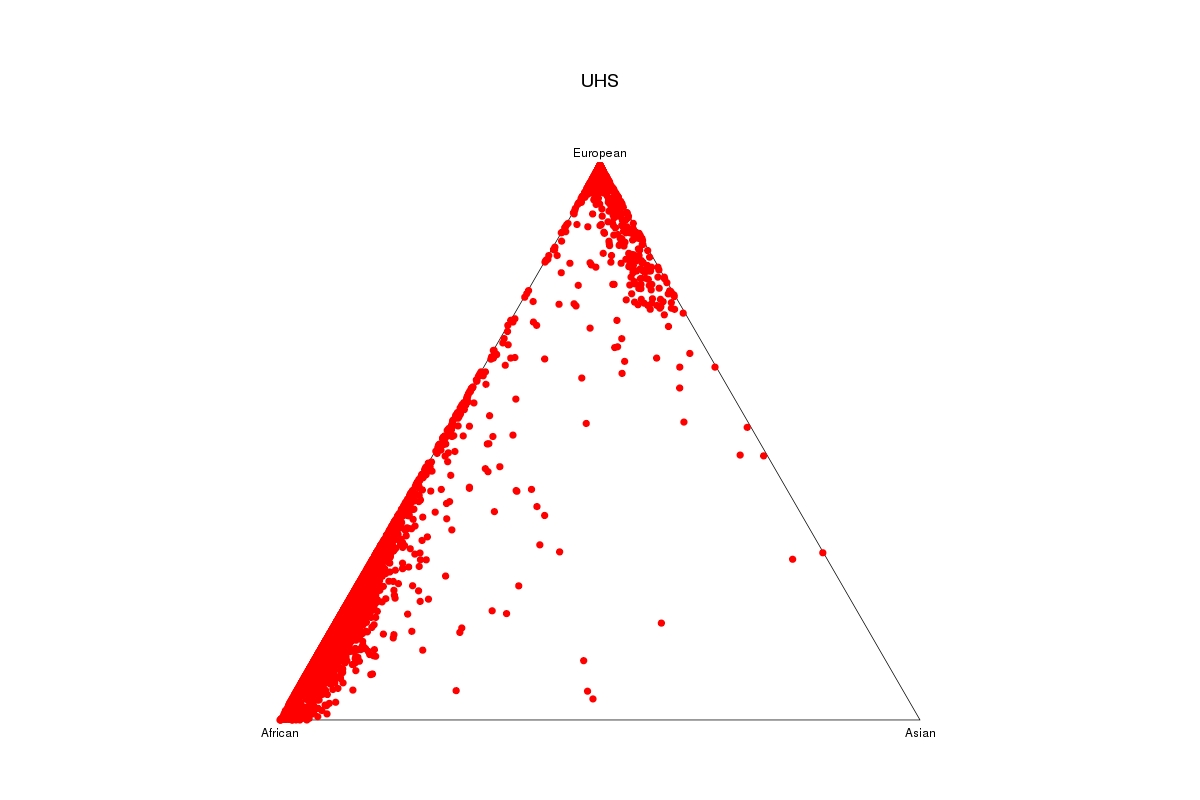### View Plots

In [ ]:
library("IRdisplay")
display_png(file="/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/structure/1KG/afr_eas_eur_UHS.jpg", width=800, height=800)

#### Thresholding
The following retainment thresholds should be implemented:

| Ancestry |Pre-Filtering Subject Count|Post-Filtering Subject Count | Retainment Thresholds     |
|----------|---------------------------|-----------------------------|---------------------------|
| EA       | 3,036                     | 3,023                       | (AFR < 25%) ∧ (EAS < 25%) |
| AA       | 4,033                     | 4,026                       | (AFR > 25%) ∧ (EAS < 25%) |
| HA       | 0                         | 13                          | (AFR < 25%) ∧ (EAS > 25%) |

```
ww afr_eas_eur.triangle_input
7070 afr_eas_eur.triangle_input
```

Seven subjects were not assigned to an ancestry group.

| ID                                   | Origninal Group   |
|--------------------------------------|---------|
| 49282@1054752684                     | uhs1_aa |
| 119705@1054753355                    | uhs1_aa |
| 232828@1054755560                    | uhs1_aa |
| 541308@1054753694                    | uhs1_aa |
| 885463@1054755444                    | uhs1_aa |
| 994455@1054755536                    | uhs1_aa |
| AS88-2170_8002023143_HHG10437_15_A01 | uhs4_aa |


```
cat ids.not.found.txt
ID
49282@1054752684
119705@1054753355
232828@1054755560
541308@1054753694
885463@1054755444
994455@1054755536
AS88-2170_8002023143_HHG10437_15_A01


grep -f structure/triangle_plots/thresholding/ids.not.found.txt uhs*/*rsid*fam
uhs1/uhs1.aa.rsid.fam:49282@1054752684 49282@1054752684 0 0 1 -9
uhs1/uhs1.aa.rsid.fam:119705@1054753355 119705@1054753355 0 0 2 -9
uhs1/uhs1.aa.rsid.fam:232828@1054755560 232828@1054755560 0 0 2 -9
uhs1/uhs1.aa.rsid.fam:541308@1054753694 541308@1054753694 0 0 2 -9
uhs1/uhs1.aa.rsid.fam:885463@1054755444 885463@1054755444 0 0 2 -9
uhs1/uhs1.aa.rsid.fam:994455@1054755536 994455@1054755536 0 0 2 -9
uhs4/uhs4.aa.rsid.fam:AS88-2170_8002023143_HHG10437_15_A01 AS88-2170_8002023143_HHG10437_15_A01 0 0 1 -9
```

In [ ]:
### get details on which subjects are reassigned ###

study=uhs
plots=${base_dir}/structure/triangle_plots/thresholding
mkdir -p $plots

cp ${base_dir}/structure/triangle_plots/afr_eas_eur.triangle_input $plots/

# AA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=AA

head -1 ${base_dir}/structure/triangle_plots/afr_eas_eur.triangle_input > \
    $plots/afr_eas_eur_filtered.triangle_input

tail -n +2 $plots/afr_eas_eur.triangle_input | \
    perl -lane 'if (($F[3] > 0.25 && $F[4] < 0.25)) { print $_ }' \
    > $plots/aa_filtered

# study=vidus, for example
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' $plots/aa_filtered >> $plots/afr_eas_eur_filtered.triangle_input


# EA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=EA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] < 0.25)) { print $_; }' \
    > $plots/ea_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' $plots/ea_filtered >> $plots/afr_eas_eur_filtered.triangle_input
#--------------------------------------------------------------------------------

# HA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=HA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] > 0.25)) { print $_; }' \
    > $plots/ha_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' $plots/ha_filtered >> $plots/afr_eas_eur_filtered.triangle_input
#--------------------------------------------------------------------------------

# subjects not assigned to any ancestry group
comm -23 <(cut -f1 afr_eas_eur.triangle_input | sort) \
         <(cut -f1 afr_eas_eur_filtered.triangle_input | sort) > not.found.tmp
head -1 ../*xref | cut -f2 > ids.not.found.txt
awk 'NR==FNR{map[$1]=$2; next} {print substr(map[$1],1,length(map[$1])/2)}' ../*xref not.found.tmp >> ids.not.found.txt


# Generate filtered triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data $plots/afr_eas_eur_filtered.triangle_input \
    --prefix $plots/afr_eas_eur_filtered \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref $base_dir/structure/triangle_plots/afr_eas_eur_id_xref

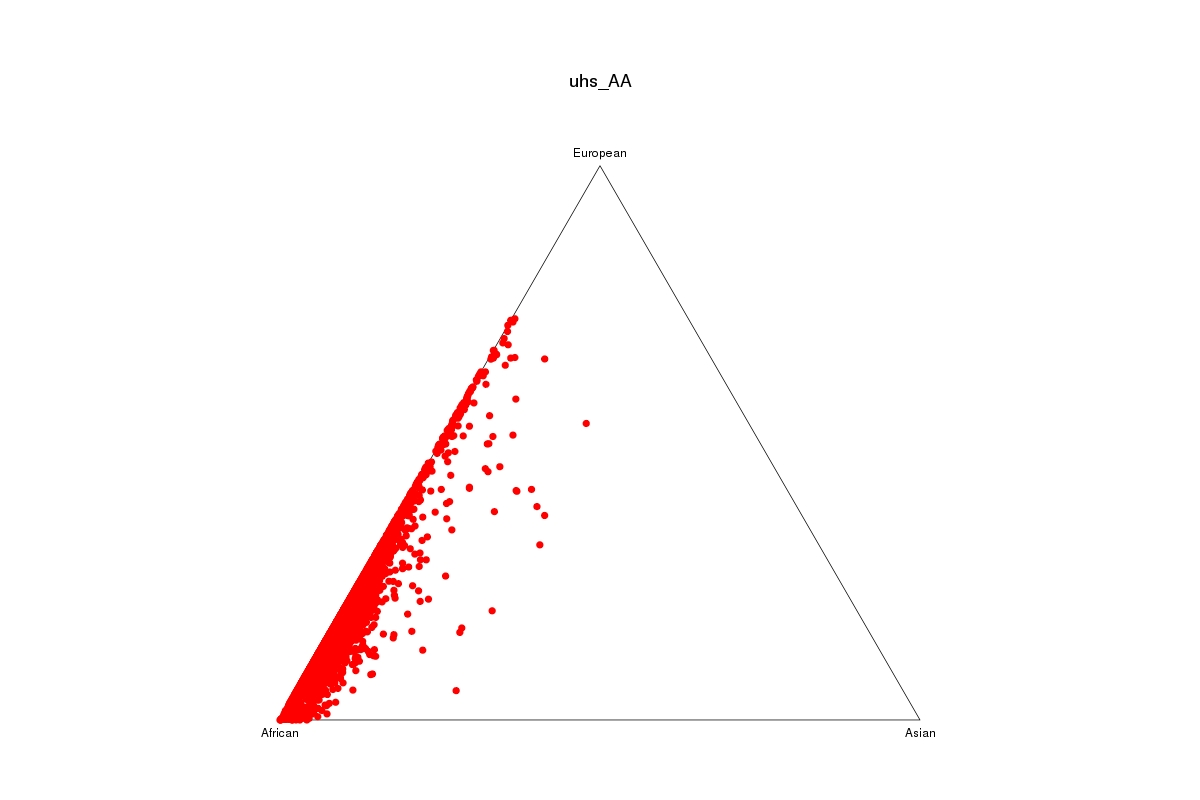
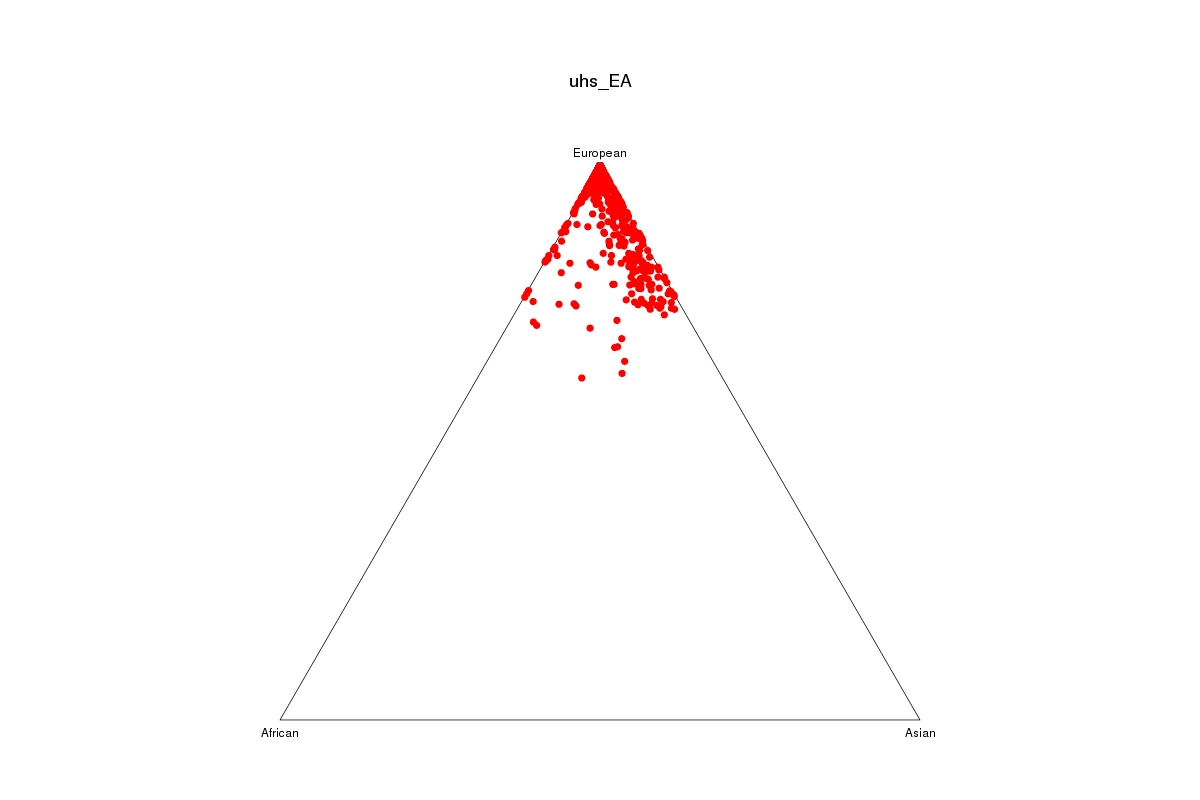

In [ ]:
library("IRdisplay")
display_png(file="/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/structure/1KG/filtered/afr_eas_eur_filtered_uhs_AA.jpg", width=800, height=800)
display_png(file="/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/structure/1KG/filtered/afr_eas_eur_filtered_uhs_EA.jpg", width=800, height=800)

In [ ]:
for ancestry in ea aa; do
    echo $ancestry
    for study in {uhs1,uhs2,uhs3_v1-2,uhs3_v1-3,uhs4}; do
        ww $study/$study.$ancestry.rsid.fam
    done
    echo 
done

3036, 4033
"""
ea
1142 uhs1/uhs1.ea.rsid.fam
828 uhs2/uhs2.ea.rsid.fam
33 uhs3_v1-2/uhs3_v1-2.ea.rsid.fam
44 uhs3_v1-3/uhs3_v1-3.ea.rsid.fam
989 uhs4/uhs4.ea.rsid.fam

aa
2016 uhs1/uhs1.aa.rsid.fam
767 uhs2/uhs2.aa.rsid.fam
84 uhs3_v1-2/uhs3_v1-2.aa.rsid.fam
94 uhs3_v1-3/uhs3_v1-3.aa.rsid.fam
1072 uhs4/uhs4.aa.rsid.fam
"""

# Post-Structure Data Processing
## Create updated PLINK filesets
**Note**, for UHS1 & UHS4, there were two participants that changed ancestry groups after the STRUCTURE analysis. Because of this, we will have to merge the EA and AA data for those two subgroups and then partition the combined data into their respective ancestry groups based on the ID lists produced from the structure analysis. We did not have to do this with the other UHS subgroups because there were no individuals that changed ancestry groups after the STRUCTURE analysis. 

In [ ]:
anlist="ea aa"

# get ancestry counts after filtering + create a keepIDs list
for an in $anlist;do
    awk -v an="${an^^}" -v study="$study" '$3==study"_"an {print $2}' \
        $plots/afr_eas_eur_filtered_for_filtering.txt > ${plots}/$an.subject_ids.keep
    wc -l ${plots}/$an.subject_ids.keep
done
"""
3023 /shared/jmarks/hiv/uhs1-4/structure/triangle_plots/thresholding/ea.subject_ids.keep
4026 /shared/jmarks/hiv/uhs1-4/structure/triangle_plots/thresholding/aa.subject_ids.keep
"""

# split famID_IID up by space --> famID" "IID
for an in $anlist;do
    while read line;do
        half=$(expr ${#line} / 2)
        echo ${line:0:$half} ${line:0:$half}
    done < ${plots}/$an.subject_ids.keep > ${plots}/$an.subject_ids.keep.txt
done


## uhs1: merge ancestries
study=uhs1            
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile ${base_dir}/$study/uhs1.aa \
    --bmerge ${base_dir}/$study/uhs1.ea \
    --make-bed \
    --out $base_dir/$study/$study.aa+ea.1KG.structure
            
## uhs4: merge ancestries
study=uhs4
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile ${base_dir}/$study/uhs4.merged2.aa \
    --bmerge ${base_dir}/$study/uhs4.merged2.ea \
    --make-bed \
    --out $base_dir/$study/$study.aa+ea.1KG.structure
            
## partition UHS1 and UHS4 into respective ancestry groups ##
for study in uhs1 uhs4; do
    for an in $anlist; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --bfile $base_dir/$study/$study.aa+ea.1KG.structure \
            --keep $plots/$an.subject_ids.keep.txt \
            --make-bed \
            --out $base_dir/data/$study/genotype/observed/$an/$study.$an.1KG.structure
    done
done

            
# uhs2
study=uhs2
for an in $anlist;do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --bfile $base_dir/$study/$study.$an \
        --keep $plots/$an.subject_ids.keep.txt \
        --make-bed \
        --out $base_dir/data/$study/genotype/observed/$an/$study.$an.1KG.structure
done
            
# uhs3_v1-2
study=uhs3_v1-2
for an in $anlist;do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --bfile $base_dir/$study/uhs3.$an.V1-2 \
        --keep $plots/$an.subject_ids.keep.txt \
        --make-bed \
        --out $base_dir/data/$study/genotype/observed/$an/$study.$an.1KG.structure
done
            
# uhs3_v1-3
study=uhs3_v1-3
for an in $anlist;do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --bfile $base_dir/$study/uhs3.$an.V1-3 \
        --keep $plots/$an.subject_ids.keep.txt \
        --make-bed \
        --out $base_dir/data/$study/genotype/observed/$an/$study.$an.1KG.structure
done

```
 ww */*/*/aa/*bim
   812321 uhs1/genotype/observed/aa/uhs1.aa.1KG.structure.bim
  1395852 uhs2/genotype/observed/aa/uhs2.aa.1KG.structure.bim
  1845925 uhs3_v1-2/genotype/observed/aa/uhs3_v1-2.aa.1KG.structure.bim
  1806719 uhs3_v1-3/genotype/observed/aa/uhs3_v1-3.aa.1KG.structure.bim
  2094455 uhs4/genotype/observed/aa/uhs4.aa.1KG.structure.bim
  
 ww */*/*/ea/*bim
   812321 uhs1/genotype/observed/ea/uhs1.ea.1KG.structure.bim
  1820881 uhs2/genotype/observed/ea/uhs2.ea.1KG.structure.bim
  1924758 uhs3_v1-2/genotype/observed/ea/uhs3_v1-2.ea.1KG.structure.bim
  1868610 uhs3_v1-3/genotype/observed/ea/uhs3_v1-3.ea.1KG.structure.bim
  2094455 uhs4/genotype/observed/ea/uhs4.ea.1KG.structure.bim
```

In [ ]:
# Break out data by chr
for study in $study_list; do
    for ancestry in $anlist; do
        for chr in {1..23}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 2048 \
                --bfile $thouN/${ancestry}_chr_all \
                --chr ${chr} \
                --make-bed \
                --out $thouN/${ancestry}_chr${chr}
        done
    done
done

# Rename study autosome variant IDs
for ancestry in $anlist; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name recode_to_1000g_${chr} \
            --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
            --mem 6 \
            --nslots 1 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
                --file_in $thouN/${ancestry}_chr${chr}.bim \
                --file_out $thouN/${ancestry}_chr${chr}_renamed.bim \
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
                --file_in_header 0 \
                --file_in_id_col 1 \
                --file_in_chr_col 0 \
                --file_in_pos_col 3 \
                --file_in_a1_col 4 \
                --file_in_a2_col 5 \
                --chr ${chr}
    done
done


# Rename study chrX variant IDs
chr=23
for ancestry in $anlist; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
        --mem 6 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in $thouN/${ancestry}_chr${chr}.bim \
            --file_out $thouN/${ancestry}_chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done

## GRCh37 strand and allele discordance check
### MAF for study data

In [ ]:
ancestry_list="aa ea"
# write out the MAF report
for study in ${study_list}; do
    study_dir=${base_dir}/processing/${study}/strand_check
    mkdir ${study_dir}
    for ancestry in ${ancestry_list};do
        data_dir=${base_dir}/data/${study}/genotype/observed/${ancestry}
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bed ${data_dir}/*bed\
            --bim ${data_dir}/*bim\
            --fam ${data_dir}/*fam\
            --freq \
            --out ${study_dir}/${ancestry}_${base_name}
    done
done

studies=($study_list)  #studies=(uhs1 uhs2 uhs3_v1-2 uhs3_v1-3 uhs4) # array of study names
num=${#studies[@]}

## Get intersection set
for ancestry in ${ancestry_list};do
    bim_files=()
    for (( i=0; i<${num}; i++ ));do
        bim_files+=(${base_dir}/data/${studies[$i]}/genotype/observed/$ancestry/*bim)
    done
    
    echo -e "\nCalculating intersection between $ancestry ${study_list}...\n"
    sort ${bim_files[@]}|  uniq -dc | awk -v num=$num '$1 == num {print $3}' \
        > ${base_dir}/processing/intersect/${ancestry}_variant_intersection.txt
    ww ${base_dir}/processing/intersect/${ancestry}_variant_intersection.txt
done &

```
347942 /shared/jmarks/hiv/uhs1-4/processing/intersect/aa_variant_intersection.txt
385919 /shared/jmarks/hiv/uhs1-4/processing/intersect/ea_variant_intersection.txt
```

### MAF for 1KG
This pipeline is currently set up to handle EUR and AFR populations.

####  Autosomes
Get 1000G MAF for chromosomes 1–22 (autosomes).

In [ ]:
# Calculate autosome MAFs for 1000G populations
for ancestry in ${ancestry_list}; do

    if [ $ancestry == "ea" ]; then
        pop="EUR"
    elif [ $ancestry == "ha" ]; then
        pop="AMR";
    else
        pop="AFR"
    fi
    
    for chr in {21..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr}_MAF \
            --script_prefix ${base_dir}/processing/1000g/${pop}_chr${chr}.maf \
            --mem 6.8 \
            --nslots 3 \
            --priority 0 \
            --program /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
                --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.hap.gz\
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.legend.gz \
                --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
                --chr ${chr} \
                --out ${base_dir}/processing/1000g/${pop}_chr${chr}.maf \
                --extract ${base_dir}/processing/intersect/${ancestry}_variant_intersection.txt \
                --keep_groups ${pop}
    done
done

#### chrX
Get 1000G MAF for chromosome 23 (chrX).

In [ ]:
chr=23
for ancestry in ${ancestry_list};do

    if [ $ancestry == "ea" ]
    then
        pop="EUR"
    elif [ $ancestry == "ha" ]; then
        pop="AMR"
    else
        pop="AFR"
    fi

    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_23_MAF \
        --script_prefix ${base_dir}/processing/1000g/${pop}_chr${chr}.maf \
        --mem 6.8 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
            --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.hap.gz\
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
            --chr $chr \
            --out ${base_dir}/processing/1000g/${pop}_chr${chr}.maf \
            --extract ${base_dir}/processing/intersect/${ancestry}_variant_intersection.txt \
            --keep_groups ${pop}
done

### Merge 1000G chromosomes
Only need to perform this if there were multiple chromosomes for which the MAF was calculated—e.g. more than just chrX.

In [ ]:
# Merge per chr MAFs for each 1000G population
for ancestry in ${ancestry_list};do
    if [ $ancestry == "ea" ]
    then
        pop="EUR"
    elif [ $ancestry == "ha" ]; then
        pop="AMR"
    else
        pop="AFR"
    fi
    
    head -n 1 ${base_dir}/processing/1000g/${pop}_chr1.maf >\
        ${base_dir}/processing/1000g/${pop}_chr_all.maf
    tail -q -n +2 ${base_dir}/processing/1000g/${pop}_chr??maf  >>\
        ${base_dir}/processing/1000g/${pop}_chr_all.maf
    
    wc -l $base_dir/processing/1000g/${pop}_chr_all.maf
done

```
198239 /shared/jmarks/hiv/uhs1-4/processing/1000g/AFR_chr_all.maf
219841 /shared/jmarks/hiv/uhs1-4/processing/1000g/EUR_chr_all.maf
```

###  Allele Discordances Check
The allele discordances will be resolved by

* Flipping allele discordances that are fixed by flipping
* Removing SNPs with discordant names
* Removing SNPs with discordant positions
* Removing allele discordances that are not resolved by flipping
* Removing alleles with large deviations from the reference population allele frequencies

Given that the allele discordance check was done using a union set of SNPs across all studies within an ancestry group, some of the SNPs logged as discordant for a given study may not actually be in the study. Fortunately, if they are not in a given study they will not interfere with the filtering procedures. Note that the intersection set is used for the final studies merger.

####  Autosomes

In [ ]:
# Run discordance checks for each ancestry group
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        if [ $ancestry = "ea" ]; then
            pop=EUR
        elif [ $ancestry = "ha" ]; then
            pop=AMR
        else
            pop=AFR
        fi

       /shared/bioinformatics/software/scripts/qsub_job.sh \
           --job_name ${ancestry}_${study}_crosscheck \
           --script_prefix ${base_dir}/processing/$study/strand_check/${ancestry}_allele_discordance_check \
           --mem 6 \
           --nslots 3 \
           --priority 0 \
           --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R
               --study_bim_file ${base_dir}/data/${study}/genotype/observed/${ancestry}/*bim
               --study_frq_file ${base_dir}/processing/${study}/strand_check/${ancestry}_chr_all.frq
               --ref_maf_file ${base_dir}/processing/1000g/${pop}_chr_all.maf
               --out_prefix ${base_dir}/processing/${study}/strand_check/${ancestry}_allele_discordance"
    done
done

####  chrX
Only run the following code if you are only processing chrX (i.e. without the autosomes).

In [ ]:
#for study in ${study_list}; do
#    for ancestry in ${ancestry_list};do
#        if [ $ancestry = "ea" ]; then
#            pop=EUR
#        elif [ $ancestry == "ha" ]; then
#            pop=AMR
#        else
#            pop=AFR
#        fi
#
#        # chr23 discordance check
#        /shared/bioinformatics/software/scripts/qsub_job.sh \
#            --job_name ${ancestry}_${study}_crosscheck_chr$chr \
#            --script_prefix ${base_dir}/processing/${study}/strand_check/${ancestry}_allele_discordance_check \
#            --mem 6.8 \
#            --nslots 1 \
#            --priority 0 \
#            --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R
#                --study_bim_file ${base_dir}/data/${study}/genotype/observed/${ancestry}/*bim
#                --study_frq_file ${base_dir}/processing/${study}/strand_check/${ancestry}_chr23.frq
#                --ref_maf_file ${base_dir}/processing/1000g/${pop}_chr23.maf
#                --out_prefix ${base_dir}/processing/${study}/strand_check/${ancestry}_allele_discordance_chr23"
#    done
#done

### Resolving Allele Discordances

In [ ]:
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        echo -e "\n===============\nProcessing ${study}_${ancestry}\n"
        echo "Making remove list"
        cat <(cut -f2,2 ${base_dir}/processing/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_not_fixed_by_strand_flip | tail -n +2) \
            <(cut -f2,2 ${base_dir}/processing/${study}/strand_check/${ancestry}_allele_discordance.at_cg_snps_freq_diff_gt_0.2 | tail -n +2) \
            <(cut -f2,2 ${base_dir}/processing/${study}/strand_check/${ancestry}_allele_discordance.discordant_names | tail -n +2) \
            <(cut -f2,2 ${base_dir}/processing/${study}/strand_check/${ancestry}_allele_discordance.discordant_positions | tail -n +2) \
            <(cut -f2,2 ${base_dir}/processing/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip | tail -n +2) | \
              sort -u > ${base_dir}/processing/${study}/strand_check/${ancestry}_snps.remove

        # Create flip list
        echo "Making flip list"
        comm -23 <(cut -f2,2 ${base_dir}/processing/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles | tail -n +2 | sort -u) \
                 <(cut -f2,2 ${base_dir}/processing/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_not_fixed_by_strand_flip | tail -n +2 | sort -u) \
                 > ${base_dir}/processing/${study}/strand_check/${ancestry}_snps.flip

        # Apply filters
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bed     ${base_dir}/data/${study}/genotype/observed/${ancestry}/*bed \
            --bim     ${base_dir}/data/${study}/genotype/observed/${ancestry}/*bim \
            --fam     ${base_dir}/data/${study}/genotype/observed/${ancestry}/*fam \
            --exclude ${base_dir}/processing/${study}/strand_check/${ancestry}_snps.remove \
            --flip    ${base_dir}/processing/${study}/strand_check/${ancestry}_snps.flip \
            --make-bed \
            --out     ${base_dir}/processing/${study}/${ancestry}_filtered
    done
done

wc -l $base_dir/processing/*/*bim

```
   812297 /shared/jmarks/hiv/uhs1-4/processing/uhs1/aa_filtered.bim
   812295 /shared/jmarks/hiv/uhs1-4/processing/uhs1/ea_filtered.bim
  1395851 /shared/jmarks/hiv/uhs1-4/processing/uhs2/aa_filtered.bim
  1820880 /shared/jmarks/hiv/uhs1-4/processing/uhs2/ea_filtered.bim
  1845924 /shared/jmarks/hiv/uhs1-4/processing/uhs3_v1-2/aa_filtered.bim
  1924757 /shared/jmarks/hiv/uhs1-4/processing/uhs3_v1-2/ea_filtered.bim
  1806717 /shared/jmarks/hiv/uhs1-4/processing/uhs3_v1-3/aa_filtered.bim
  1868608 /shared/jmarks/hiv/uhs1-4/processing/uhs3_v1-3/ea_filtered.bim
  2094452 /shared/jmarks/hiv/uhs1-4/processing/uhs4/aa_filtered.bim
  2094454 /shared/jmarks/hiv/uhs1-4/processing/uhs4/ea_filtered.bim
```

## Remove monomorphic variants
Monomorphic variants prevent MIS from accepting the genotype data. In this case, an arbitrarily small MAF is set that is smaller than the lower bound for these data.

In [ ]:
# Apply filters
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        geno_dir=${base_dir}/processing/${study}

        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bfile ${geno_dir}/${ancestry}_filtered \
            --maf 0.000001 \
            --make-bed \
            --out ${geno_dir}/${ancestry}_filtered_mono
    done
done

wc -l $base_dir/processing/*/*mono.bim

```
   795223 /shared/jmarks/hiv/uhs1-4/processing/uhs1/aa_filtered_mono.bim
   774623 /shared/jmarks/hiv/uhs1-4/processing/uhs1/ea_filtered_mono.bim
  1324199 /shared/jmarks/hiv/uhs1-4/processing/uhs2/aa_filtered_mono.bim
  1453050 /shared/jmarks/hiv/uhs1-4/processing/uhs2/ea_filtered_mono.bim
  1581978 /shared/jmarks/hiv/uhs1-4/processing/uhs3_v1-2/aa_filtered_mono.bim
  1198894 /shared/jmarks/hiv/uhs1-4/processing/uhs3_v1-2/ea_filtered_mono.bim
  1569241 /shared/jmarks/hiv/uhs1-4/processing/uhs3_v1-3/aa_filtered_mono.bim
  1195784 /shared/jmarks/hiv/uhs1-4/processing/uhs3_v1-3/ea_filtered_mono.bim
  1853695 /shared/jmarks/hiv/uhs1-4/processing/uhs4/aa_filtered_mono.bim
  1800983 /shared/jmarks/hiv/uhs1-4/processing/uhs4/ea_filtered_mono.bim
```

## SNP intersection
Only run if merging multiple data sets

In [ ]:
studies=($study_list)  #studies=(UHS1 UHS2 UHS3_v1-2 UHS3_v1-3) # array of study names
num=${#studies[@]}

# Get intersection set
for ancestry in ${ancestry_list};do
    bim_files=()
    for (( i=0; i<${num}; i++ ));do
        bim_files+=(${base_dir}/processing/${studies[$i]}/${ancestry}_filtered_mono.bim)
    done
    
    echo -e "\nCalculating intersection between $ancestry ${study_list}...\n"
    sort ${bim_files[@]} | uniq -dc | awk -v num=$num '$1 == num {print $3}' \
        > ${base_dir}/processing/intersect/${ancestry}.variant_intersection.filters_applied.txt

    # Make new PLINK binary file sets
    for study in ${studies[@]}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --bfile ${base_dir}/processing/${study}/${ancestry}_filtered_mono \
            --extract ${base_dir}/processing/intersect/${ancestry}.variant_intersection.filters_applied.txt \
            --make-bed \
            --out ${base_dir}/processing/intersect/${study}_${ancestry}_filtered_snp_intersection
    done
done

### Merge test
If merging multiple datasets together:

As a final check to confirm that our data sets are all compatible, a PLINK file set merge is conducted. If any issues persist then an error will be raised.

In [ ]:
for ancestry in $ancestry_list;do
    echo "Creating $ancestry merge-list"
    touch ${base_dir}/processing/intersect/${ancestry}_merge_list.txt
    for study in $study_list;do
        echo ${base_dir}/processing/intersect/${study}_${ancestry}_filtered_snp_intersection >>\
             ${base_dir}/processing/intersect/${ancestry}_merge_list.txt
    done

# Merge file sets
    echo -e "\n\n======== ${ancestry} ========\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 4000 \
        --merge-list ${base_dir}/processing/intersect/${ancestry}_merge_list.txt \
        --make-bed \
        --out ${base_dir}/processing/intersect/${ancestry}_studies_merged
done

No errors in this case.

## Imputation preparation for Michigan Imputation Server
Visit the [MIS Getting Started Webpage](https://imputationserver.sph.umich.edu/start.html#!pages/help) for more information about the preparing the data for upload to MIS.

### VCF File Conversion

In [ ]:
### Split by chr and remove any individuals with missing data for whole chr

# if merged data sets together
for ancestry in $ancestry_list;do
    for chr in {1..23};do
        # Remove SNPs
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 4000 \
            --bfile ${base_dir}/processing/intersect/${ancestry}_studies_merged \
            --chr ${chr} \
            --mind 0.99 \
            --make-bed \
            --out ${base_dir}/processing/impute_prep/${ancestry}_chr${chr}_for_phasing 
    done > ${base_dir}/processing/impute_prep/chr_splitting.log 
done


for ancestry in $ancestry_list; do
    grep removed $base_dir/processing/impute_prep/$ancestry*log |
        perl -lne '/(\d+)(\speople)/;
             $mycount += $1; 
             print $mycount if eof'  > $base_dir/processing/impute_prep/$ancestry.removed
    any_removed=$(cat $base_dir/processing/impute_prep/$ancestry.removed)
    if [ "$any_removed" == 0 ]; then
        echo "No $ancestry subjects removed"
    else
        echo "Some $ancestry subjects removed"
    fi
done

```
No ea subjects removed
No aa subjects removed
```

In [ ]:
# EC2 command line #

for chr in {1..23};do
    for ancestry in ${ancestry_list};do
        final_dir=${base_dir}/processing/impute_prep/${ancestry}
        mkdir $final_dir
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 5000 \
            --bfile ${final_dir}/../${ancestry}_chr${chr}_for_phasing \
            --output-chr M \
            --set-hh-missing \
            --recode vcf bgz \
            --out ${final_dir}/${ancestry}_chr${chr}_final
    done
done &

Transfer the *.vcf.gz files to local machine (per chromosome) and then upload to MIS.

## Upload to Michigan Imputation Server (MIS)

### Uploading parameters
These are the parameters that were selected on MIS.

__Name__: UHS4_HA

__Reference Panel__ 1000G Phase 3 v5

__Input Files__ File Upload <br>

* Select Files - select VCF (.gz) files that were downloaded to local machine from cloud. <br>

__Phasing__: ShapeIT v2.r790 (unphased) 

__Population__: EUR

__Mode__: Quality Control & Imputation

* I will not attempt to re-identify or contact research participants.
* I will report any inadvertent data release, security breach or other data management incident of which I become aware.

# Download Imputed Results from MIS
First, download the data form the Michigan Imputation Server (MIS) by clicking on the link provided in the email they send out to alert you that your data has finished. Here you will find commands for downloading the data.

## AA
The zip files from Michigan Imputation Server (MIS) need to be inflated before you can begin working with them. They require a passcode that is sent by MIS to email.
* password: jCgePval1XM0H1

Then, inflate imputation results.

In [ ]:
ancestry=aa
study=uhs1-4
passW="'jCgePval1XM0H1'"
cd /shared/jmarks/hiv/uhs1-4_GWAS/genotype/imputed/aa


# download.file
####################################################################################################
####################################################################################################
# QC-results
wget https://imputationserver.sph.umich.edu/share/results/f1fd1bf0ba44d01697c123b26335ea7e/qcreport.html

# Imputation Results
wget https://imputationserver.sph.umich.edu/share/results/9010ad72ad259923cccd1a0a2668938f/chr_1.zip
wget https://imputationserver.sph.umich.edu/share/results/c71108b23938ca97651ceceddbca3782/chr_10.zip
wget https://imputationserver.sph.umich.edu/share/results/68f798bdcb9a6342974f150c8ecca2a/chr_11.zip
wget https://imputationserver.sph.umich.edu/share/results/6f758b1d3b9c0dc17284c9379a262529/chr_12.zip
wget https://imputationserver.sph.umich.edu/share/results/8972262f48ffa3a35d96e42e7bec9cf4/chr_13.zip
wget https://imputationserver.sph.umich.edu/share/results/2ed56b0e6999e675a82909f47133b384/chr_14.zip
wget https://imputationserver.sph.umich.edu/share/results/c3fcece2fa5a45e20af299263fcaf509/chr_15.zip
wget https://imputationserver.sph.umich.edu/share/results/b616eb15346ed0c048fb82238cef8105/chr_16.zip
wget https://imputationserver.sph.umich.edu/share/results/df6a59dd73a2b52202e1bc3118825e37/chr_17.zip
wget https://imputationserver.sph.umich.edu/share/results/414625a32c4e1080c149e53d86a88664/chr_18.zip
wget https://imputationserver.sph.umich.edu/share/results/be9acfe1b7952c5775a4414cc7fda264/chr_19.zip
wget https://imputationserver.sph.umich.edu/share/results/e95de6b1180302834f9a7f68ecddf32c/chr_2.zip
wget https://imputationserver.sph.umich.edu/share/results/ddd6a26c33c5689c54f2538e889535cc/chr_20.zip
wget https://imputationserver.sph.umich.edu/share/results/7c7ff6082c3ce3efcd2643c643188d70/chr_21.zip
wget https://imputationserver.sph.umich.edu/share/results/c418817bbfcd34706cc2bea963c099eb/chr_22.zip
wget https://imputationserver.sph.umich.edu/share/results/1ad55e153c7fd73516444facd98e1793/chr_3.zip
wget https://imputationserver.sph.umich.edu/share/results/e7c6c072fad170c9c5853fa31353584d/chr_4.zip
wget https://imputationserver.sph.umich.edu/share/results/c8f9a807eb2bbf4f23a79d36ee79bb17/chr_5.zip
wget https://imputationserver.sph.umich.edu/share/results/6ff6731c91846f4766e5b80cad0c7210/chr_6.zip
wget https://imputationserver.sph.umich.edu/share/results/4006c7bd11ed0d50ae49443e8a679d43/chr_7.zip
wget https://imputationserver.sph.umich.edu/share/results/25c07fb1e735cb11b0386c38d31e677e/chr_8.zip
wget https://imputationserver.sph.umich.edu/share/results/897dbd705282bac7020226e4d96f5c8b/chr_9.zip


# Logs
wget https://imputationserver.sph.umich.edu/share/results/29823da9db9008bae366688f0f7d0493/chr_1.log
wget https://imputationserver.sph.umich.edu/share/results/efccc235d78241eb001c7d27be510540/chr_10.log
wget https://imputationserver.sph.umich.edu/share/results/2af67a65726db426ac04080f103e04de/chr_11.log
wget https://imputationserver.sph.umich.edu/share/results/cd10b470cd13f604a75835e3bbc4c732/chr_12.log
wget https://imputationserver.sph.umich.edu/share/results/24e259221f302e7d00fbfb8e71bb2c1d/chr_13.log
wget https://imputationserver.sph.umich.edu/share/results/59cfb0f2bd9636df3d665b6592e47b87/chr_14.log
wget https://imputationserver.sph.umich.edu/share/results/b278ac9d4e36bb64a9065c8e0753ccbe/chr_15.log
wget https://imputationserver.sph.umich.edu/share/results/ab840f3b36cc9ee3d0019c696176dcb7/chr_16.log
wget https://imputationserver.sph.umich.edu/share/results/3c94f65268042785ca0851355d1f906b/chr_17.log
wget https://imputationserver.sph.umich.edu/share/results/6ae4744e32155655207a9f50162f73d3/chr_18.log
wget https://imputationserver.sph.umich.edu/share/results/76e1c719f7e388f413f82aad430ae6c1/chr_19.log
wget https://imputationserver.sph.umich.edu/share/results/3159f03b14e60e44e7fbdace8af1821/chr_2.log
wget https://imputationserver.sph.umich.edu/share/results/bfcbb45d87d70491cf650772e44ded9b/chr_20.log
wget https://imputationserver.sph.umich.edu/share/results/85ab52bed5daee3913aaa152c0941d13/chr_21.log
wget https://imputationserver.sph.umich.edu/share/results/464ea2996505876baa4b61d59da82d26/chr_22.log
wget https://imputationserver.sph.umich.edu/share/results/cc5cd914d3b0158290522db77505f5a6/chr_3.log
wget https://imputationserver.sph.umich.edu/share/results/549067c8bfcf1dafad46bc65d98f4dae/chr_4.log
wget https://imputationserver.sph.umich.edu/share/results/6796478b7908c396c84083904c819801/chr_5.log
wget https://imputationserver.sph.umich.edu/share/results/419e05700eedc1f24188f626960fecbf/chr_6.log
wget https://imputationserver.sph.umich.edu/share/results/f6313961192bd75de4d0184cc83f2613/chr_7.log
wget https://imputationserver.sph.umich.edu/share/results/e5405323c22b154700c377fd17853b2b/chr_8.log
wget https://imputationserver.sph.umich.edu/share/results/58879e696607f1c85d65e9c8dc5b9c2c/chr_9.log


# SNP Statistics
wget https://imputationserver.sph.umich.edu/share/results/34be271da2684270b6ecaa5bf8a6bf0e/statistics.txt
####################################################################################################
####################################################################################################

 
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name MIS.dowload.$study.$ancestry \
    --script_prefix imputed.data.download.$ancestry \
    --mem 3 \
    --nslots 1 \
    --priority 0 \
    --program bash download.file

# inflate chr results
for file in *zip; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name unzip.$study.$ancestry \
        --script_prefix unzip.imputed.$study.$ancestry.data \
        --mem 3 \
        --nslots 2 \
        --priority 0 \
        --program unzip -P $passW $file 
done

# we can remove the original imputed data from MIS after we inflate the zip files
rm -rf *zip

## EA
The zip files from Michigan Imputation Server (MIS) need to be inflated before you can begin working with them. They require a passcode that is sent by MIS to email.
* password: "UMTWRqXAk89rui"

Then, inflate imputation results.

In [ ]:
ancestry=ea
study=uhs1-4
passW="'UMTWRqXAk89rui'"
cd /shared/jmarks/hiv/uhs1-4_GWAS/genotype/imputed/ea


# download.file
####################################################################################################
####################################################################################################
# QC-results
wget https://imputationserver.sph.umich.edu/share/results/78d015a0138942cd843e14ae65ae3cba/qcreport.html

# Imputation Results
wget https://imputationserver.sph.umich.edu/share/results/b794dabfb8bef80b76eb235c7c80e774/chr_1.zip
wget https://imputationserver.sph.umich.edu/share/results/33db3c31a60e1d05811e5466eb249dc8/chr_10.zip
wget https://imputationserver.sph.umich.edu/share/results/fbce01d510c97fa3d17cb1104feca74a/chr_11.zip
wget https://imputationserver.sph.umich.edu/share/results/4964dfc33230199be61a3f36589e424a/chr_12.zip
wget https://imputationserver.sph.umich.edu/share/results/89fde9b7a18735242371f12066dc4f9c/chr_13.zip
wget https://imputationserver.sph.umich.edu/share/results/c4a464e42be12ecacfb746d5ae6644bd/chr_14.zip
wget https://imputationserver.sph.umich.edu/share/results/90bee4525dec2e89c829620501c74b71/chr_15.zip
wget https://imputationserver.sph.umich.edu/share/results/e8835434efa174727ff3aa81f5fffa8/chr_16.zip
wget https://imputationserver.sph.umich.edu/share/results/fa2386a6e0cbee58331932d4b3c71c69/chr_17.zip
wget https://imputationserver.sph.umich.edu/share/results/7147fc77e128168e95ad2564f7dafd4c/chr_18.zip
wget https://imputationserver.sph.umich.edu/share/results/b7e016f3b6f3f7bbc95d5480b60921d6/chr_19.zip
wget https://imputationserver.sph.umich.edu/share/results/2ffc7c8fd301e91a25fe10f4bc5dffe1/chr_2.zip
wget https://imputationserver.sph.umich.edu/share/results/5962eb8befb139b34ff9681b99e87d25/chr_20.zip
wget https://imputationserver.sph.umich.edu/share/results/b2b604b957ccccf6e366f16615c6214e/chr_21.zip
wget https://imputationserver.sph.umich.edu/share/results/5e7f66ffe0ef3f387b1516d955a5b26a/chr_22.zip
wget https://imputationserver.sph.umich.edu/share/results/6860dfeb2d483d7198c9630f38ef235/chr_3.zip
wget https://imputationserver.sph.umich.edu/share/results/34b1be287adfb37b200bfafb0f12d61d/chr_4.zip
wget https://imputationserver.sph.umich.edu/share/results/bc984d947691b32922a8e6bb25145257/chr_5.zip
wget https://imputationserver.sph.umich.edu/share/results/df5e99e074ce6adecbfd6c405ade251f/chr_6.zip
wget https://imputationserver.sph.umich.edu/share/results/2defc61534fb8c2bd410510cf2a1d00c/chr_7.zip
wget https://imputationserver.sph.umich.edu/share/results/c63d73e7d1412308890c7812297d2744/chr_8.zip
wget https://imputationserver.sph.umich.edu/share/results/f3a2af31e613abdb16fea6b929faab18/chr_9.zip


# Logs
wget https://imputationserver.sph.umich.edu/share/results/e1661fdf819a31454793c2feb497e431/chr_1.log
wget https://imputationserver.sph.umich.edu/share/results/7a2af9fd2cf74eb5709010a297dee041/chr_10.log
wget https://imputationserver.sph.umich.edu/share/results/941c7a3d879fdbe275ac40375554a437/chr_11.log
wget https://imputationserver.sph.umich.edu/share/results/1e13132f555a4cedc57f8949d2222ebd/chr_12.log
wget https://imputationserver.sph.umich.edu/share/results/1bbd7fab943e4efd48e23380711d960d/chr_13.log
wget https://imputationserver.sph.umich.edu/share/results/1a7eac1feb1726722b46f47a6b52ae60/chr_14.log
wget https://imputationserver.sph.umich.edu/share/results/7c01d74c7915fcf452eb5fb92b94342c/chr_15.log
wget https://imputationserver.sph.umich.edu/share/results/b1f5ecde9d682fa68570295fe7813362/chr_16.log
wget https://imputationserver.sph.umich.edu/share/results/cbc969135ec90f670bcf76c9b94f0648/chr_17.log
wget https://imputationserver.sph.umich.edu/share/results/60939e5626a55c4dadb5dcf347c0a05e/chr_18.log
wget https://imputationserver.sph.umich.edu/share/results/2832ed0b5fb33d2b55f84fbb52b99117/chr_19.log
wget https://imputationserver.sph.umich.edu/share/results/cfdf9b15af3ae449bfa95027208a7de0/chr_2.log
wget https://imputationserver.sph.umich.edu/share/results/3b4921a03a03e7beb963dd4fef27257/chr_20.log
wget https://imputationserver.sph.umich.edu/share/results/34f418e49440837024c9d4b6803cb07/chr_21.log
wget https://imputationserver.sph.umich.edu/share/results/d55886018a598db523bc991d36eec9cb/chr_22.log
wget https://imputationserver.sph.umich.edu/share/results/9c7c18828d948d5299365898951efad7/chr_3.log
wget https://imputationserver.sph.umich.edu/share/results/6832ef8d0e1286222f505996994c515f/chr_4.log
wget https://imputationserver.sph.umich.edu/share/results/4403fb18d1a0817ec05d2c259c5221b3/chr_5.log
wget https://imputationserver.sph.umich.edu/share/results/728e0820fbd53bb8020287d486ef9f97/chr_6.log
wget https://imputationserver.sph.umich.edu/share/results/2f0e3ef042014247fb53057751cce367/chr_7.log
wget https://imputationserver.sph.umich.edu/share/results/6a37070a4cfa9b8df51c7fca37ab2ce0/chr_8.log
wget https://imputationserver.sph.umich.edu/share/results/a51a054225ddfdb840a2173ceedf725d/chr_9.log


# SNP Statistics
wget https://imputationserver.sph.umich.edu/share/results/195a23887cf349f3a4c3247223137081/statistics.txt
####################################################################################################
####################################################################################################

/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name MIS.dowload.$study.$ancestry \
    --script_prefix imputed.data.download.$ancestry \
    --mem 3 \
    --nslots 1 \
    --priority 0 \
    --program bash download.file

# inflate chr results
for file in *zip; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name unzip.$study.$ancestry \
        --script_prefix unzip.imputed.$study.$ancestry.data \
        --mem 3 \
        --nslots 2 \
        --priority 0 \
        --program unzip -P $passW $file 
done

# we can remove the original imputed data from MIS after we inflate the zip files
rm -rf *zip

# Upload to S3

In [ ]:
ancestry=aa
cd /shared/jmarks/hiv/uhs1234/gwas/genotype/imputed/$ancestry

/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name s3.upload.$ancestry \
    --script_prefix s3.upload.$ancestry \
    --mem 3 \
    --nslots 2 \
    --priority 0 \
    --program aws s3 sync . s3://rti-hiv/hiv_uhs1234/data/genotype/imputed/$ancestry

# Sandbox
UHS1 UHS3_v1-2 intersection
```
532748 /shared/jmarks/hiv/uhs1-4/processing/intersect/aa_variant_intersection.txt.test
549355 /shared/jmarks/hiv/uhs1-4/processing/intersect/ea_variant_intersection.txt.test
```

UHS1 & UHS2 intersection
```
443483 /shared/jmarks/hiv/uhs1-4/processing/intersect/aa_variant_intersection.txt.test
540190 /shared/jmarks/hiv/uhs1-4/processing/intersect/ea_variant_intersection.txt.test
```

UHS1 & UHS4 intersection
```
  580101 aa_variant_intersection.txt
  580101 ea_variant_intersection.txt
```

UHS2 & UHS4 intersection
```
 1243686 aa_variant_intersection.txt.text
 1577821 ea_variant_intersection.txt.text
```


UHS3_v1-2 & UHS4 intersection
```
1582607 /shared/jmarks/hiv/uhs1-4/processing/intersect/aa_variant_intersection.txt.test
1643860 /shared/jmarks/hiv/uhs1-4/processing/intersect/ea_variant_intersection.txt.test
```

In [ ]:
## Get intersection set
study_list="uhs1 uhs2"
studies=($study_list)
num=${#studies[@]}
for ancestry in ${ancestry_list};do
    bim_files=()
    for (( i=0; i<${num}; i++ ));do
        bim_files+=(${base_dir}/data/${studies[$i]}/genotype/observed/$ancestry/*bim)
    done
    
    echo -e "\nCalculating intersection between $ancestry ${study_list}...\n"
    sort ${bim_files[@]}| cut -f2 | uniq -dc | awk -v num=$num '$1 == num {print $2}' \
        > ${base_dir}/processing/intersect/${ancestry}_variant_intersection.txt.test
    ww ${base_dir}/processing/intersect/${ancestry}_variant_intersection.txt.test
done &